In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

print('Tensorflow version: ', tf.__version__)
print('matplotlib version: ', matplotlib.__version__)
print('numpy version: ', np.__version__)


Tensorflow version:  2.1.0
matplotlib version:  3.0.3
numpy version:  1.18.2


In [2]:
#hyperparameters
latent_dim = 100
lr = 1e-4
epochs = 1000
K = 2 #number of iterations for the discriminator
batch_size = 512
dropout_rate = 0.2
beta_1 = 0.9 # for the adam optimizer
seed = 500
save_interval = 50 


In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.Dense_1 = tf.keras.layers.Dense(256)
        self.Dense_2 = tf.keras.layers.Dense(28*28, activation='sigmoid')
        
        self.reshape = tf.keras.layers.Reshape((28,28,1))
    
    def call(self, inputs):
        x = self.Dense_1(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.Dense_2(x)
        x = self.reshape(x)
        return x

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        
        self.Dense_1 = tf.keras.layers.Dense(256)

        self.Dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.Dense_1(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.dropout_1(x)
        x = self.Dense_2(x)
        return x

In [6]:
gen = Generator()
disc = Discriminator()

(60000, 28, 28, 1)


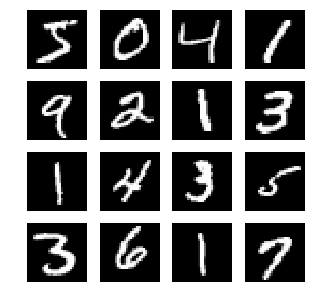

In [7]:
#loading the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # load the dataset
x_train = tf.cast(x_train, tf.float32)/255. #normalize the dataset
x_train = x_train[..., tf.newaxis] # add the channel axis
x_test = tf.cast(x_test, tf.float32)/255.
x_test = x_test[..., tf.newaxis]
print(x_train.shape) 
#visualize some of the dataset
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i, :, :, 0] * 255.0, cmap='gray')
    plt.axis('off')

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [10]:
gen_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=False)
gen_opt = tf.keras.optimizers.Adam(gen_lr_schedule, beta_1=beta_1)

disc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=False)
disc_opt = tf.keras.optimizers.Adam(disc_lr_schedule, beta_1=beta_1)

In [11]:
@tf.function
def train_step(images, batch_size):
    #train the discriminator
    total_discLoss = 0
    for i in range(K):
        noise = tf.random.normal([batch_size, latent_dim])

        with tf.GradientTape() as tape:
            gen_images = gen(noise)

            real_prob = disc(images)
            generated_prob =  disc(gen_images)      

            disc_loss = -tf.reduce_mean(tf.math.log(real_prob) + tf.math.log(1. - generated_prob))
            total_discLoss += disc_loss
            
        tf.debugging.check_numerics(disc(gen_images), 'disc prob of generated images') 
        tf.debugging.check_numerics(tf.math.log(real_prob), 'disc loss real prob part')
        tf.debugging.check_numerics(tf.math.log(1. - generated_prob), 'disc loss gen prob part')

        grad_disc = tape.gradient(disc_loss, disc.trainable_variables)
        disc_opt.apply_gradients(zip(grad_disc, disc.trainable_variables))
        
    mean_disc_loss = total_discLoss/K

    #train the generator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        generated_prob = disc(gen_images)
                
        gen_loss = -tf.reduce_mean(tf.math.log(generated_prob))
        
    tf.debugging.check_numerics(tf.math.log(generated_prob), 'gen loss part')
    
    grad_gen = tape.gradient(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    
    # accuracy of the discriminator to detect the real images
    disc_real_acc = tf.reduce_mean(1 - (tf.ones_like(real_prob) - tf.cast(real_prob>=0.5, tf.float32))) 
    #accuracy of the discriminator on generated images, if this one is low then the disciminator is failing to dtect generated images
    disc_gen_acc = tf.reduce_mean(tf.ones_like(generated_prob) - tf.cast(generated_prob>=0.5, tf.float32)) 
    
    return gen_loss, mean_disc_loss, disc_real_acc, disc_gen_acc


In [21]:
def save_gen_imgs(epoch, generator, noise=None):
    if noise is None:
        noise = tf.random.normal([16, latent_dim])
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs.numpy()
    fig = plt.figure(figsize=(5, 5))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0]*255, cmap='gray')
        plt.axis('off')
    fig.savefig("gen_images/image_{}.png".format(str(epoch).zfill(5)))
    plt.close(fig)

def status_printing(status_list):
    status_epoch = str(status_list[0]).zfill(4)
    status_epoch_time = str(round(status_list[1], 2)).zfill(5)
    status_gen_loss = str(round(status_list[2], 3)).zfill(6)
    status_disc_loss = str(round(status_list[3], 3)).zfill(5)
    status_disc_real_acc = str(round(status_list[4], 2)).zfill(4)
    status_disc_gen_acc = str(round(status_list[5], 2)).zfill(4)
    print('Epoch {}, {} sec, gen_loss = {}, disc_loss = {}, disc_real_acc = {}, disc_gen_acc = {}'.format(status_epoch, 
                                                                                                          status_epoch_time, 
                                                                                                          status_gen_loss, 
                                                                                                          status_disc_loss, 
                                                                                                          status_disc_real_acc,
                                                                                                          status_disc_gen_acc))
    

In [13]:
vis_noise = tf.random.normal([16, latent_dim])

In [14]:
gen_loss_list = []
disc_loss_list = []
training_start_time = time.time()
for epoch in range(epochs):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    total_disc_real_acc = 0
    total_disc_gen_acc = 0
    count = 0

    for images,labels in train_ds:
        batch_s = images.shape[0]
        gen_loss, disc_loss, disc_real_acc, disc_gen_acc = train_step(images, batch_s)

        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        total_disc_real_acc += disc_real_acc
        total_disc_gen_acc += disc_gen_acc
        count += 1
    #calculate avergae metrics over the epoch
    avg_gen_loss = total_gen_loss.numpy()/count
    avg_disc_loss = total_disc_loss.numpy()/count
    avg_disc_real_acc = total_disc_real_acc.numpy()/count
    avg_disc_gen_acc = total_disc_gen_acc.numpy()/count
    
    gen_loss_list.append(avg_gen_loss)
    disc_loss_list.append(avg_disc_loss)
    
    #printing training status
    status_list = [epoch + 1, time.time() - start, avg_gen_loss, avg_disc_loss, 
                   avg_disc_real_acc, avg_disc_gen_acc]
    status_printing(status_list)
    
                                                                                                   
    if epoch % save_interval == 0:
        save_gen_imgs(epoch, gen, vis_noise)
save_gen_imgs(epoch, gen, vis_noise)        
training_time_in_hrs = (time.time() - training_start_time) / (60*60)
print('Total training time: {} hrs'.format(training_time_in_hrs))

Epoch 0001, 03.33 sec, gen_loss = 05.012, disc_loss = 0.092, disc_real_acc = 0.99, disc_gen_acc = 01.0
Epoch 0002, 01.72 sec, gen_loss = 07.173, disc_loss = 0.034, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0003, 002.0 sec, gen_loss = 05.661, disc_loss = 00.09, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0004, 02.64 sec, gen_loss = 004.29, disc_loss = 0.098, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0005, 002.5 sec, gen_loss = 04.318, disc_loss = 0.061, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0006, 01.65 sec, gen_loss = 04.491, disc_loss = 0.045, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0007, 01.57 sec, gen_loss = 04.706, disc_loss = 0.035, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0008, 01.59 sec, gen_loss = 004.77, disc_loss = 0.034, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0009, 01.57 sec, gen_loss = 04.742, disc_loss = 0.041, disc_real_acc = 01.0, disc_gen_acc = 01.0
Epoch 0010, 001.6 sec, gen_loss = 04.631, disc_loss = 0.058, disc_real_ac

Epoch 0081, 01.75 sec, gen_loss = 03.329, disc_loss = 0.277, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0082, 01.72 sec, gen_loss = 003.29, disc_loss = 0.288, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0083, 01.73 sec, gen_loss = 03.316, disc_loss = 0.278, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0084, 001.8 sec, gen_loss = 03.305, disc_loss = 0.275, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0085, 01.83 sec, gen_loss = 03.295, disc_loss = 0.278, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0086, 02.15 sec, gen_loss = 03.341, disc_loss = 0.273, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0087, 002.1 sec, gen_loss = 03.335, disc_loss = 0.278, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0088, 01.87 sec, gen_loss = 003.35, disc_loss = 0.272, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0089, 01.88 sec, gen_loss = 03.334, disc_loss = 0.271, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0090, 01.78 sec, gen_loss = 03.346, disc_loss = 0.272, disc_real_ac

Epoch 0161, 001.8 sec, gen_loss = 03.367, disc_loss = 0.265, disc_real_acc = 0.93, disc_gen_acc = 0.97
Epoch 0162, 01.72 sec, gen_loss = 03.363, disc_loss = 0.267, disc_real_acc = 0.93, disc_gen_acc = 0.97
Epoch 0163, 01.72 sec, gen_loss = 03.378, disc_loss = 0.261, disc_real_acc = 0.93, disc_gen_acc = 0.97
Epoch 0164, 01.72 sec, gen_loss = 03.395, disc_loss = 0.254, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0165, 01.68 sec, gen_loss = 03.392, disc_loss = 00.26, disc_real_acc = 0.93, disc_gen_acc = 0.97
Epoch 0166, 001.6 sec, gen_loss = 03.423, disc_loss = 0.256, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0167, 01.54 sec, gen_loss = 03.401, disc_loss = 0.254, disc_real_acc = 0.93, disc_gen_acc = 0.97
Epoch 0168, 01.54 sec, gen_loss = 03.425, disc_loss = 0.254, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0169, 01.67 sec, gen_loss = 03.435, disc_loss = 0.254, disc_real_acc = 0.94, disc_gen_acc = 0.97
Epoch 0170, 01.66 sec, gen_loss = 03.444, disc_loss = 0.254, disc_real_ac

Epoch 0241, 01.81 sec, gen_loss = 03.338, disc_loss = 0.289, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0242, 01.79 sec, gen_loss = 003.34, disc_loss = 0.291, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0243, 01.72 sec, gen_loss = 03.375, disc_loss = 0.286, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0244, 01.74 sec, gen_loss = 03.349, disc_loss = 0.285, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0245, 001.8 sec, gen_loss = 03.368, disc_loss = 0.285, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0246, 01.81 sec, gen_loss = 03.414, disc_loss = 00.28, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0247, 01.82 sec, gen_loss = 03.348, disc_loss = 0.287, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0248, 01.79 sec, gen_loss = 03.349, disc_loss = 0.283, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0249, 001.8 sec, gen_loss = 03.412, disc_loss = 00.28, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0250, 01.89 sec, gen_loss = 03.352, disc_loss = 0.289, disc_real_ac

Epoch 0321, 01.74 sec, gen_loss = 03.312, disc_loss = 0.278, disc_real_acc = 0.92, disc_gen_acc = 0.98
Epoch 0322, 01.72 sec, gen_loss = 03.291, disc_loss = 0.288, disc_real_acc = 0.92, disc_gen_acc = 0.98
Epoch 0323, 01.79 sec, gen_loss = 03.359, disc_loss = 0.271, disc_real_acc = 0.92, disc_gen_acc = 0.98
Epoch 0324, 01.78 sec, gen_loss = 03.328, disc_loss = 0.284, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0325, 01.72 sec, gen_loss = 03.305, disc_loss = 0.281, disc_real_acc = 0.92, disc_gen_acc = 0.98
Epoch 0326, 01.73 sec, gen_loss = 03.329, disc_loss = 0.281, disc_real_acc = 0.92, disc_gen_acc = 0.98
Epoch 0327, 01.73 sec, gen_loss = 03.298, disc_loss = 0.285, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0328, 01.79 sec, gen_loss = 03.323, disc_loss = 0.283, disc_real_acc = 0.92, disc_gen_acc = 0.97
Epoch 0329, 01.78 sec, gen_loss = 03.294, disc_loss = 0.295, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0330, 01.72 sec, gen_loss = 03.352, disc_loss = 0.283, disc_real_ac

Epoch 0401, 01.85 sec, gen_loss = 03.305, disc_loss = 0.298, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0402, 01.78 sec, gen_loss = 03.291, disc_loss = 0.305, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0403, 01.83 sec, gen_loss = 03.289, disc_loss = 0.308, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0404, 01.88 sec, gen_loss = 03.305, disc_loss = 0.305, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0405, 01.86 sec, gen_loss = 003.31, disc_loss = 0.305, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0406, 01.78 sec, gen_loss = 03.311, disc_loss = 0.303, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0407, 01.81 sec, gen_loss = 03.301, disc_loss = 0.308, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0408, 01.71 sec, gen_loss = 03.344, disc_loss = 0.302, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0409, 01.71 sec, gen_loss = 03.303, disc_loss = 0.314, disc_real_acc = 0.91, disc_gen_acc = 0.97
Epoch 0410, 01.66 sec, gen_loss = 03.284, disc_loss = 0.315, disc_real_ac

Epoch 0481, 01.83 sec, gen_loss = 003.22, disc_loss = 0.339, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0482, 01.72 sec, gen_loss = 03.195, disc_loss = 0.351, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0483, 01.67 sec, gen_loss = 03.217, disc_loss = 0.338, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0484, 01.74 sec, gen_loss = 03.194, disc_loss = 0.344, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0485, 01.88 sec, gen_loss = 03.218, disc_loss = 0.337, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0486, 02.18 sec, gen_loss = 03.205, disc_loss = 0.348, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0487, 02.36 sec, gen_loss = 03.232, disc_loss = 0.342, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0488, 02.68 sec, gen_loss = 03.193, disc_loss = 0.351, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0489, 02.63 sec, gen_loss = 03.209, disc_loss = 0.342, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0490, 02.49 sec, gen_loss = 03.212, disc_loss = 0.344, disc_real_ac

Epoch 0561, 02.75 sec, gen_loss = 003.13, disc_loss = 0.363, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0562, 02.28 sec, gen_loss = 03.157, disc_loss = 0.352, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0563, 02.11 sec, gen_loss = 03.107, disc_loss = 0.366, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0564, 01.87 sec, gen_loss = 03.117, disc_loss = 0.353, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0565, 01.91 sec, gen_loss = 03.131, disc_loss = 0.366, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0566, 01.86 sec, gen_loss = 03.158, disc_loss = 0.349, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0567, 01.77 sec, gen_loss = 03.093, disc_loss = 0.374, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0568, 01.91 sec, gen_loss = 03.147, disc_loss = 0.351, disc_real_acc = 00.9, disc_gen_acc = 0.96
Epoch 0569, 02.11 sec, gen_loss = 03.108, disc_loss = 0.361, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0570, 02.83 sec, gen_loss = 03.102, disc_loss = 0.363, disc_real_ac

Epoch 0641, 01.88 sec, gen_loss = 03.067, disc_loss = 0.367, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0642, 001.8 sec, gen_loss = 03.064, disc_loss = 0.372, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0643, 001.8 sec, gen_loss = 03.067, disc_loss = 0.375, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0644, 01.75 sec, gen_loss = 0003.1, disc_loss = 0.361, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0645, 01.74 sec, gen_loss = 03.046, disc_loss = 0.378, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0646, 01.73 sec, gen_loss = 03.113, disc_loss = 00.36, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0647, 001.8 sec, gen_loss = 03.038, disc_loss = 0.385, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0648, 01.79 sec, gen_loss = 03.124, disc_loss = 0.359, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0649, 01.72 sec, gen_loss = 03.075, disc_loss = 0.378, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0650, 01.73 sec, gen_loss = 03.083, disc_loss = 00.37, disc_real_ac

Epoch 0721, 01.89 sec, gen_loss = 03.049, disc_loss = 0.374, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0722, 01.85 sec, gen_loss = 03.029, disc_loss = 0.373, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0723, 02.33 sec, gen_loss = 03.046, disc_loss = 0.372, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0724, 02.66 sec, gen_loss = 03.028, disc_loss = 0.377, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0725, 02.77 sec, gen_loss = 03.047, disc_loss = 0.363, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0726, 002.8 sec, gen_loss = 003.01, disc_loss = 0.382, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0727, 002.5 sec, gen_loss = 03.038, disc_loss = 0.377, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0728, 002.5 sec, gen_loss = 03.029, disc_loss = 0.372, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0729, 002.1 sec, gen_loss = 003.02, disc_loss = 0.376, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0730, 01.95 sec, gen_loss = 03.015, disc_loss = 0.386, disc_real_ac

Epoch 0801, 02.15 sec, gen_loss = 002.99, disc_loss = 0.377, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0802, 01.88 sec, gen_loss = 02.961, disc_loss = 0.378, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0803, 01.93 sec, gen_loss = 02.986, disc_loss = 0.375, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0804, 02.33 sec, gen_loss = 02.994, disc_loss = 0.379, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0805, 002.5 sec, gen_loss = 02.986, disc_loss = 0.379, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0806, 02.63 sec, gen_loss = 03.006, disc_loss = 0.372, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0807, 02.61 sec, gen_loss = 03.008, disc_loss = 0.383, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0808, 002.4 sec, gen_loss = 03.012, disc_loss = 00.37, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0809, 02.13 sec, gen_loss = 02.979, disc_loss = 0.386, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0810, 02.02 sec, gen_loss = 03.049, disc_loss = 0.367, disc_real_ac

Epoch 0881, 01.88 sec, gen_loss = 02.968, disc_loss = 0.383, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0882, 02.11 sec, gen_loss = 02.982, disc_loss = 0.369, disc_real_acc = 0.88, disc_gen_acc = 0.97
Epoch 0883, 02.65 sec, gen_loss = 002.94, disc_loss = 00.39, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0884, 002.3 sec, gen_loss = 002.99, disc_loss = 0.367, disc_real_acc = 0.89, disc_gen_acc = 0.96
Epoch 0885, 02.19 sec, gen_loss = 02.969, disc_loss = 0.376, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0886, 01.88 sec, gen_loss = 02.963, disc_loss = 0.378, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0887, 001.9 sec, gen_loss = 02.971, disc_loss = 0.378, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0888, 01.81 sec, gen_loss = 02.962, disc_loss = 0.377, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0889, 01.78 sec, gen_loss = 02.943, disc_loss = 0.377, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0890, 001.8 sec, gen_loss = 02.962, disc_loss = 0.376, disc_real_ac

Epoch 0961, 02.09 sec, gen_loss = 02.955, disc_loss = 0.372, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0962, 01.85 sec, gen_loss = 02.944, disc_loss = 0.379, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0963, 01.86 sec, gen_loss = 02.962, disc_loss = 0.372, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0964, 02.13 sec, gen_loss = 02.949, disc_loss = 0.373, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0965, 02.11 sec, gen_loss = 02.942, disc_loss = 0.383, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0966, 01.84 sec, gen_loss = 02.967, disc_loss = 0.366, disc_real_acc = 0.89, disc_gen_acc = 0.97
Epoch 0967, 01.85 sec, gen_loss = 02.948, disc_loss = 0.372, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0968, 02.15 sec, gen_loss = 002.96, disc_loss = 00.38, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0969, 02.14 sec, gen_loss = 02.954, disc_loss = 00.37, disc_real_acc = 0.88, disc_gen_acc = 0.96
Epoch 0970, 01.89 sec, gen_loss = 02.923, disc_loss = 00.38, disc_real_ac

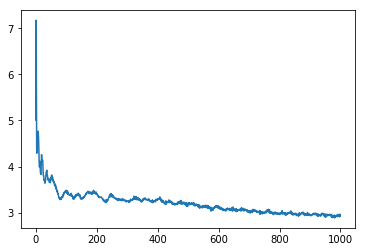

In [15]:
plt.plot(gen_loss_list)
plt.show()

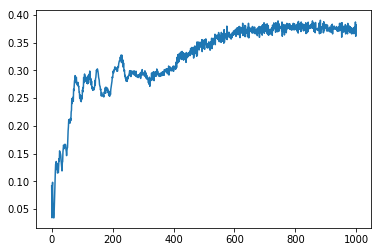

In [16]:
plt.plot(disc_loss_list)
plt.show()

In [17]:
gen.save_weights('weights/gen_weights.h5')
disc.save_weights('weights/disc_weights.h5')

In [18]:
#load generator weights
# gen(vis_noise) #to set the input shape of the generator in case of loading the weights without the training step
# gen.load_weights('weights/gen_weights.h5')


In [20]:
#Evaluating the generator

import kdeGauss # https://github.com/Sdhir/Kernel-Density-Estimation-using-Mixture-of-Gaussians
import importlib
importlib.reload(kdeGauss)

sample_size = 100

gen_data = gen(tf.random.normal([sample_size, latent_dim])).numpy()
gen_data = gen_data.reshape(gen_data.shape[0], -1)
gen_valid = gen(tf.random.normal([sample_size, latent_dim])).numpy()
gen_valid = gen_valid.reshape(gen_data.shape[0], -1)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test[:sample_size*10], y_test[:sample_size*10])).shuffle(10000).batch(sample_size)

sigma = np.logspace(-1, 0, 20)
likelihood_values = [] # list to store mean of log-likelihood values
for sg in sigma:
    kde_prob = kdeGauss.model(gen_data, gen_valid, sg)
    likelihood_values.append(kde_prob)

max_idx = np.argmax(likelihood_values)
#Optimal sigma
sigma_optimal = sigma[max_idx]
print("Optimal sigma from training = {}".format(sigma_optimal))

start_test = time.time()
print ("----  Predicting model with optimal sigma ----")
list_l = []
for images,labels in test_ds:
    batch_s = images.shape[0]
    test_data = images.numpy()
    test_data = test_data.reshape(test_data.shape[0], -1)
    L_test = kdeGauss.model(gen_data,test_data,sigma_optimal)
    list_l.append(float(L_test))

print ("mean Log liklihood = {}, se = {}".format(np.mean(list_l), np.std(list_l)/np.sqrt(x_test.numpy().shape[0])))
run_time = time.time() - start_test
print("--- Run time on test data is {} seconds ---".format(run_time))


Optimal sigma from training = 0.20691380811147897
----  Predicting model with optimal sigma ----
mean Log liklihood = -193.26959, se = 0.28241996625962906
--- Run time on test data is 1.5790565013885498 seconds ---


In [24]:
save_gen_imgs(1000, gen, noise=None)